# Student Performance Regression Analysis

# Imports

In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import chi2_contingency, f_oneway, anderson

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer, r2_score,explained_variance_score
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor

# Functions

In [109]:
def check_nulls_dupes(df):
  print(f"Number of Nulls: {df.isna().sum()}")
  print(f"Number of Duplicates: {df.duplicated().sum()}")

def plot_distribution(df, dist_type):
  
  plt.figure(figsize=(16, 16))
  rows = len(df.columns)
  dims = (rows+ 4)//3
  
  for idx, col in enumerate(df.columns):
    plt.subplot(dims, 4, idx+1)
    sns.histplot(df[col], kde=True) if dist_type == "hist" else sns.boxplot(df[col])
    plt.title(f"Distirbution of {col}") if dist_type == "hist" else plt.title(f"Boxplot of {col}")
  plt.tight_layout()
  plt.show()

def dist_plot(df, col):
  salary_skewness = df[col].skew()
  salary_kurtosis = df[col].kurtosis()

  plt.figure(figsize=(10, 6))
  sns.histplot(df[col], kde=True, color='blue')
  plt.title(f'Distribution of {col} with Skewness and Kurtosis')
  plt.xlabel(col)
  plt.ylabel('Frequency')

  plt.text(x=0.95, y=0.85, s=f"Skewness: {salary_skewness:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')
  plt.text(x=0.95, y=0.80, s=f"Kurtosis: {salary_kurtosis:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')

  plt.grid(True)
  plt.show()

def check_class_imbalance(target):
  unique, counts = np.unique(target, return_counts=True)
  
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.legend()
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.xlabel("Target Class Breakdown")
  plt.ylabel("Counts")
  plt.show()

def aggregate_dataset(df, interested_columns, agg_col, function):
  
  plt.figure(figsize=(12,12))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(interested_columns):
    if col == agg_col:
      continue
    plt.subplot(rows ,4, idx+1)
    grouped_df = getattr(df.groupby(agg_col)[col], function)().reset_index(name=col)
    sns.barplot(data=grouped_df, x=agg_col, y=col)
    plt.title(f"Agg of {col}")
    plt.ylabel(col)
    plt.xticks(rotation =45)
  plt.tight_layout()
  plt.show()

def create_preprocessor(numeric_cols, categorical_cols):
  
  numeric_transformer = Pipeline(
    steps=[("Scaler", StandardScaler())
    ]
  )
  
  categorical_transformer = Pipeline(
    steps=[
      ("Encoder", OneHotEncoder())
    ]
  )
  
  return ColumnTransformer(
    transformers = [
      ("Categorical", categorical_transformer, categorical_cols),
      ("Numeric", numeric_transformer, numeric_cols)
    ]
  )

def create_sklearn_pipeline(preprocessor, model, kbest=None):
  steps = [
    ("preprocessor", preprocessor),
    ("model", model)
  ]
  
  if kbest:
    steps.insert(1, ("Feature Selection", kbest))
  
  return Pipeline(steps=steps)

def mapping_function(val):
  grade = None
  if val >=90:
    grade = "A"
  elif val >= 80 and val <=90:
    grade = "B"
  elif val>= 70 and val <=79:
    grade = "C"
  elif val >=60 and val<=69:
    grade = "D"
  else:
    grade = "F"
  
  return grade

def scatter_plot(df, interested_columns, target):
  
  plt.figure(figsize=(12,10))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(interested_columns):
    if col == target:
      continue
    plt.subplot(rows ,3, idx+1)
    sns.scatterplot(data=df, x=target, y=col, hue=col)
  plt.tight_layout()
  plt.show()

def histogram(df, interested_columns):
  
  plt.figure(figsize=(14,12))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(interested_columns):
    if col == "grade":
      continue
    ax = plt.subplot(rows ,3, idx+1)
    sns.histplot(df[col], kde=False, ax=ax, stat='density', bins=20, color='blue', label=f'Data Histogram for {col}')
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, np.mean(df[col]), np.std(df[col]))
    ax.plot(x, p, 'k', linewidth=2, color='red', label='Normal Distribution')
    
    title = f"{col.split()[0]}: mu = {np.mean(df[col]):.2f}, std = {np.std(df[col]):.2f}"
    ax.set_title(title)
    ax.legend()
  plt.tight_layout()
  plt.show()

def side_by_side(best, worst, intersted_columns, target):
  
  for col in intersted_columns:
    if col == target:
      break
    mean_scores_best = best[col].mean()
    mean_scores_worst = worst[col].mean()

    labels = ['Best Students', 'Worst Students']
    means = [mean_scores_best, mean_scores_worst]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, means, width, label=f'Mean {col}')

    ax.set_ylabel('Scores')
    ax.set_title(f'Comparison of {col} Best vs Worst Students')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    for rect in rects1:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

    plt.show()

def chi_value_tests(df, interested_columns, target):
  
  for col in interested_columns:
    print(f"Column Is: {col}")
    contingency_table = pd.crosstab(df[target], df[col])
    chi2, p_val, _, _ = chi2_contingency(contingency_table)
    print(f"Chi-Square Test:\nChi2 Statistic: {chi2}, P-value: {p_val}")

def anderson_darling_test(df, interested_columns):
  
  for col in interested_columns:
    print(f"------------{col.upper()}------------")
    result = anderson(df[col], dist='norm')
    print('Statistic: %.3f' % result.statistic)
    for i in range(len(result.critical_values)):
      sl, cv = result.significance_level[i], result.critical_values[i]
      if result.statistic < cv:
          print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
      else:
          print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

def pca_analysis(X, preprocessor):
  
  features = range(1, X.shape[1]+1)
  metric_tracker = []
  
  for component in features:
    pca = PCA(n_components=component)
    pipeline = create_sklearn_pipeline(preprocessor, pca)
    X_pca = pipeline.fit_transform(X)
    cumsum = np.sum(pca.explained_variance_ratio_)
    
    metric_tracker.append({
      "Component":component,
      "CumSum": cumsum
    })
  
  df = pd.DataFrame(metric_tracker)
  plt.figure(figsize=(20, 12))
  plt.title("PCA Analysis")
  plt.xlabel("Component")
  plt.ylabel("CumSum")
  sns.barplot(data=df, x="Component", y="CumSum")
  plt.show()
  return df

def get_selected_models(names):
  models = {
        "SVR": SVR(),
        "LR": LinearRegression(),
        "KNN": KNeighborsRegressor(),
        "GBR": GradientBoostingRegressor(),
        "RFR": RandomForestRegressor(),
        "XGB": XGBRegressor(),
        "LASSO": Lasso(),
        "RIDGE": Ridge(),
        "DUMMY": DummyRegressor(strategy="mean")
    }
    
  return [models[model] for model in names]

def get_metrics(y, predictions):
    mae = mean_absolute_error(y, predictions)
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mean_squared_error(y, predictions))
    r2 = r2_score(y, predictions)
    exp = explained_variance_score(y, predictions)
    
    return [mae, mse, rmse, r2, exp]

def evaluate_model(model, X, y, metric):
    cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=1)
    scores = cross_val_score(model, X, y, cv=cv, scoring=metric, n_jobs=-1)
    preds = cross_val_predict(model, X, y, n_jobs=-1, cv=10)
    mae, mse, rmse, r2, exp = get_metrics(y, preds)
    
    return [
        round(np.mean(scores), 3), 
        round(np.var(scores), 3), 
        round(np.std(scores), 3), 
        round(mae, 3), 
        round(mse, 3),
        round(np.sqrt(rmse), 3),
        round(r2, 3),
        round(exp, 3)
    ]

def test_selected_models(preprocessor, model_names, models, X, y, scoring_metric, kbest=None):
    metric_tracker = []
    
    for model, model_name in zip(models, model_names):
        pipeline = create_sklearn_pipeline(preprocessor, model, kbest) if kbest else create_sklearn_pipeline(preprocessor,model) 
        scores = evaluate_model(pipeline, X, y, scoring_metric)
        metric_tracker.append({
            "Model": model_name,
            "Mean": scores[0],
            "Var": scores[1],
            "STD": scores[2],
            "MAE": scores[3],
            "MSE": scores[4],
            "RMSE": scores[5],
            "R2": scores[6],
            "Explained Var": scores[7]
        })
    
    return pd.DataFrame(metric_tracker).sort_values(by="RMSE", ascending=True)

def test_kbest_columns(preprocessor ,X, y, model, model_name, kbest):
  
  metric_tracker = []
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
  for k in range(1, X.shape[1]+1):
    metric = SelectKBest(score_func=kbest, k=k)
    pipeline = create_sklearn_pipeline(preprocessor, model, metric)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    mae, mse, rmse, r2, exp = get_metrics(y_test, y_pred)

    metric_tracker.append({
            "Model": model_name,
            'K':k,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R2": r2,
            "Explained Var": exp
        })
    
  return pd.DataFrame(metric_tracker)

def optimization_search(preprocessor, model_names, models,X, y, optimizer_class, param_distributions, scoring_metric, kbest):
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
  metric_tracker = []
  
  for model_name, model in zip(model_names, models):
    model_pipeline = create_sklearn_pipeline(preprocessor, model, kbest)

    current_params = param_distributions.get(model_name, {})
    opt_search= optimizer_class(model_pipeline, param_distributions=current_params, cv=10, scoring=scoring_metric, n_jobs=-1)
    opt_search.fit(X_train, y_train)
    
    best_model = opt_search.best_estimator_
    best_params = opt_search.best_params_
    y_pred = best_model.predict(X_test)
    
    mae, mse, rmse, r2, exp = get_metrics(y_test, y_pred)
      
    print(f"The Best Param: {best_params} for Model: {model_name}")
    metric_tracker.append({
            "Model": model_name,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R2": r2,
            "Explained Var": exp
        })
  
  return pd.DataFrame(metric_tracker).sort_values(by="RMSE", ascending=True)

def residual_plot(models, model_names, preprocessor, kbest, X, y):
  
  
  for model, model_name in zip(models, model_names):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    pipeline = create_sklearn_pipeline(preprocessor, model, kbest)
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    residuals = y_test - predictions

    plt.figure(figsize=(10, 6))
    plt.scatter(predictions, residuals, alpha=0.5)
    plt.title(f'Residual Plot for {model_name}')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.grid(True)
    plt.show()
    
    plt.scatter(y_test, predictions)
    plt.show()
  


# EDA Analysis

In [2]:
df = pd.read_csv("/Users/maukanmir/Downloads/data.csv")
df

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0
...,...,...,...,...,...,...
9995,1,49,Yes,4,2,23.0
9996,7,64,Yes,8,5,58.0
9997,6,83,Yes,8,5,74.0
9998,9,97,Yes,7,0,95.0


# Check for Dupes and Nulls

In [4]:
check_nulls_dupes(df)

Number of Nulls: Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64
Number of Duplicates: 127


In [5]:
df[df.duplicated()]

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
915,9,52,No,5,9,48.0
1477,7,61,Yes,6,8,54.0
1601,5,99,No,7,5,89.0
1786,2,62,Yes,9,4,40.0
2026,5,87,Yes,6,7,74.0
...,...,...,...,...,...,...
9644,4,91,Yes,4,3,71.0
9940,8,95,No,5,2,90.0
9954,6,97,No,8,7,92.0
9966,1,41,No,7,3,12.0


In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df.dtypes

Hours Studied                         int64
Previous Scores                       int64
Extracurricular Activities           object
Sleep Hours                           int64
Sample Question Papers Practiced      int64
Performance Index                   float64
dtype: object

In [8]:
df.describe()

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,9873.000000,9873.000000,9873.000000,9873.000000,9873.000000
mean,4.992100,69.441102,6.531652,4.583004,55.216651
std,2.589081,17.325601,1.697683,2.867202,19.208570
min,1.000000,40.000000,4.000000,0.000000,10.000000
25%,3.000000,54.000000,5.000000,2.000000,40.000000
50%,5.000000,69.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,8.000000,7.000000,70.000000
max,9.000000,99.000000,9.000000,9.000000,100.000000


# Feature Engineering

In [10]:
visual_df = df.copy()

In [12]:
visual_df["Extracurricular Activities"] = visual_df["Extracurricular Activities"].apply(lambda x: 1 if x =="Yes" else 0)

# Heat Map

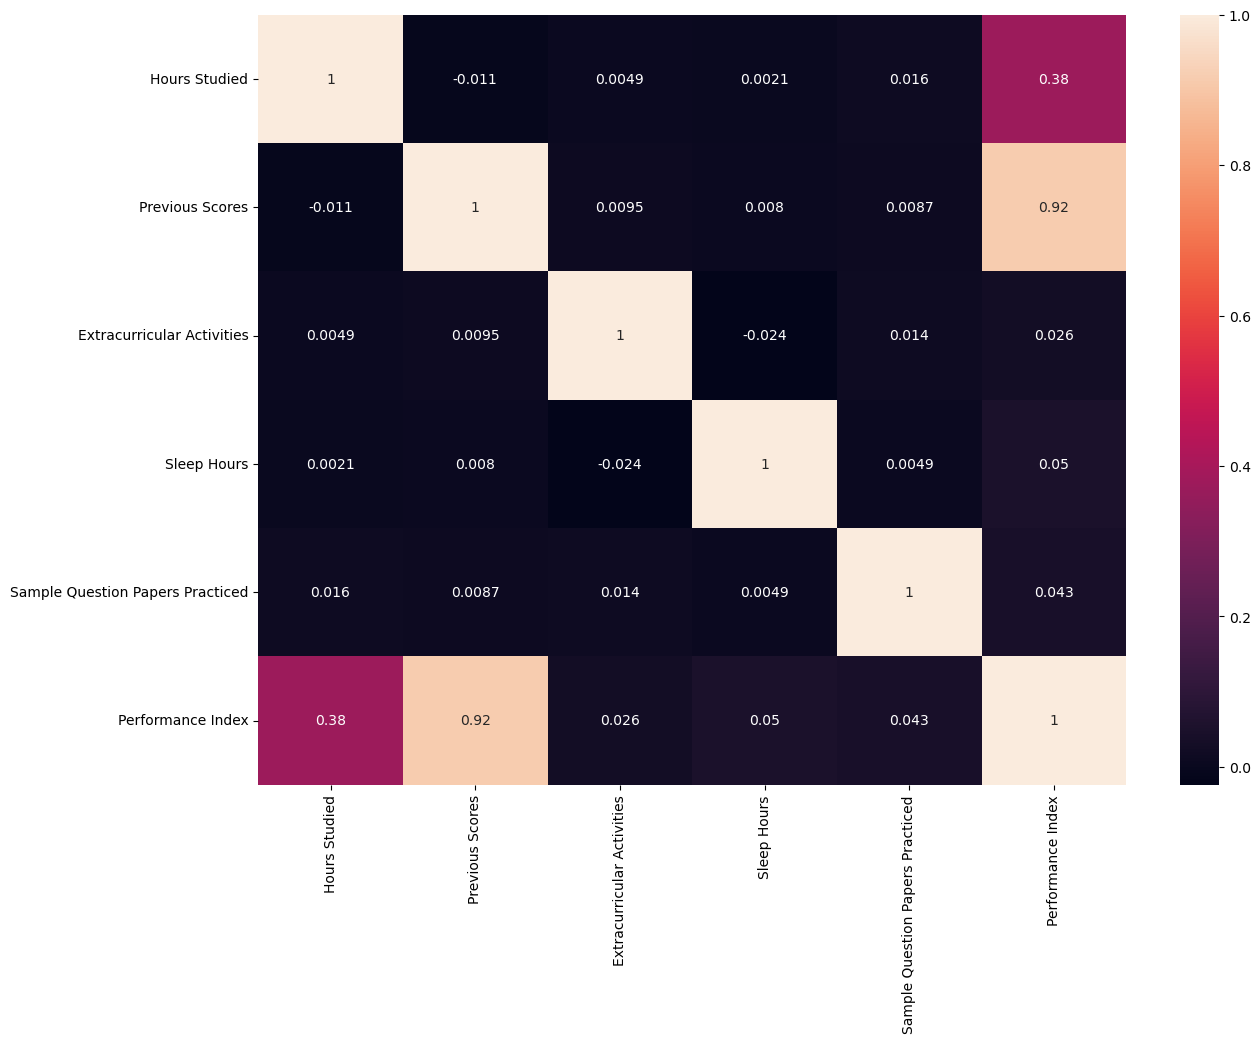

In [17]:
plt.figure(figsize=(14, 10))
relations = visual_df.corr()
sns.heatmap(data=relations,annot=True)
plt.show()

# Histogram

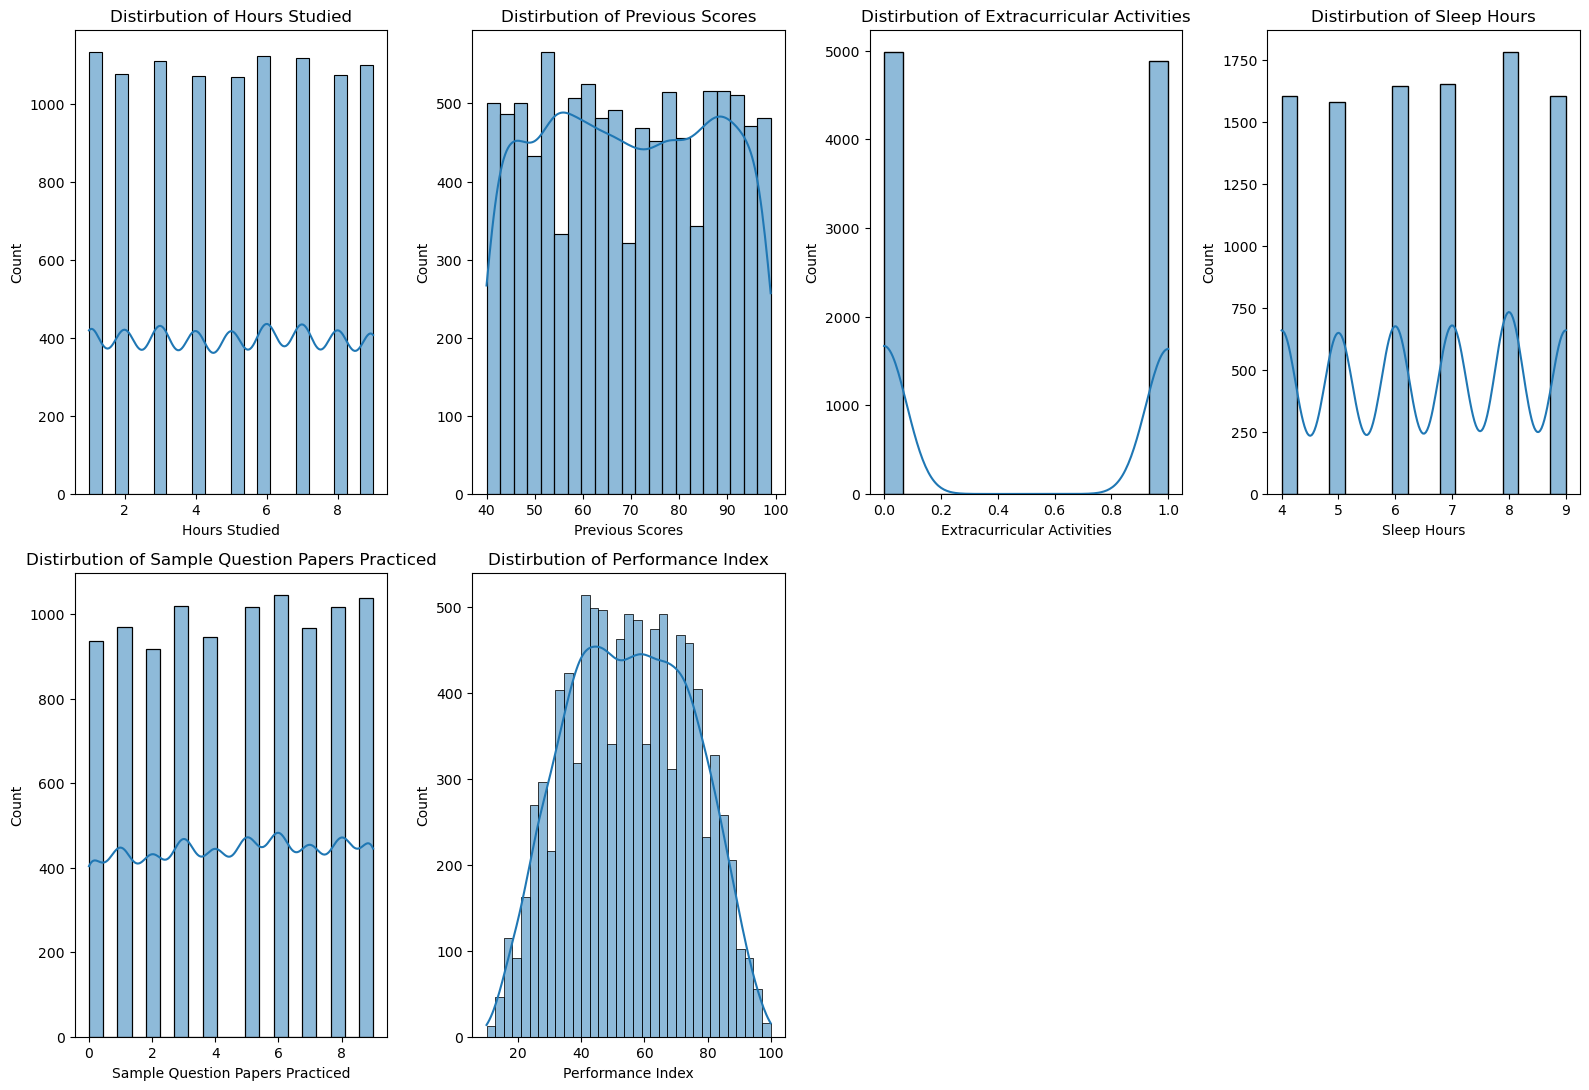

In [20]:
plot_distribution(visual_df, "hist")

# Box Plot

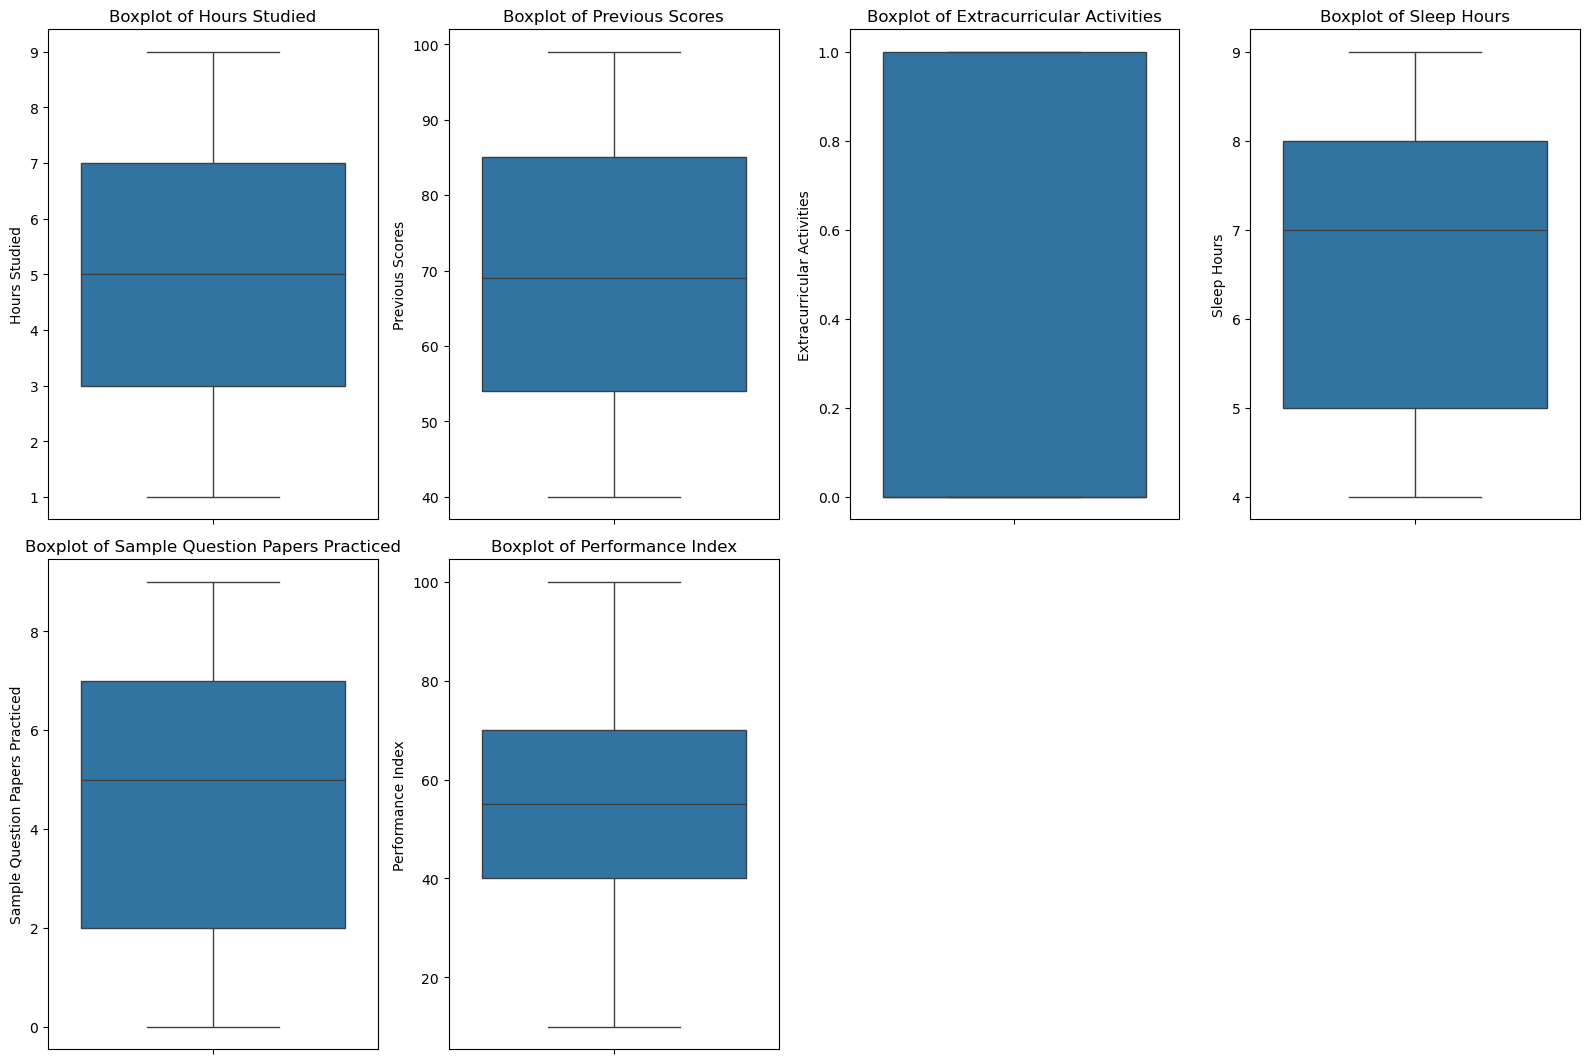

In [21]:
plot_distribution(visual_df, "box")

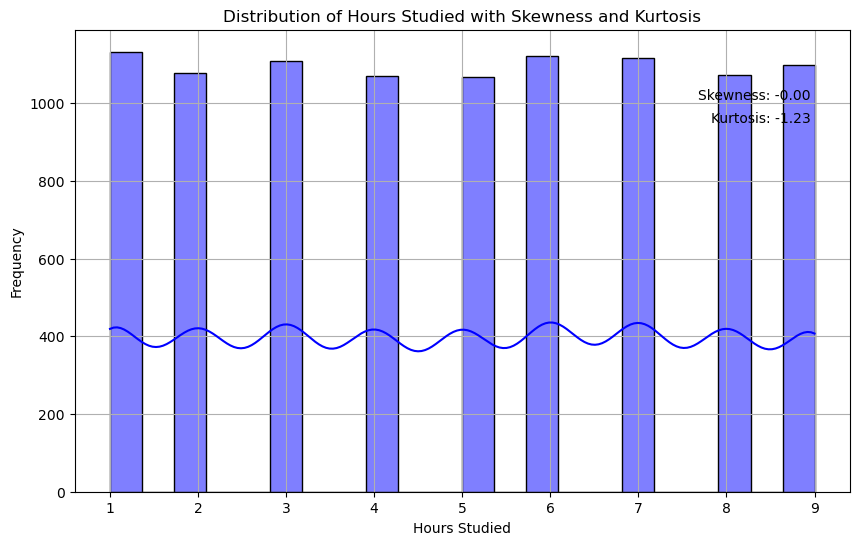

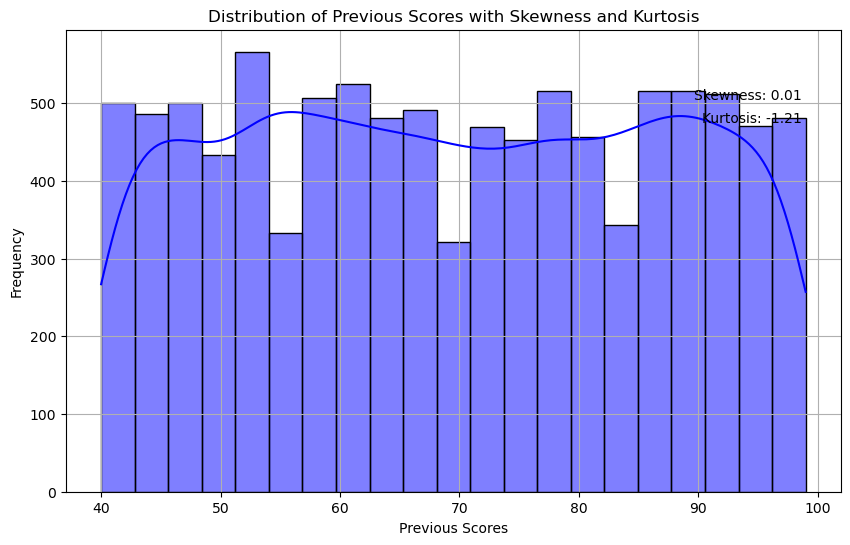

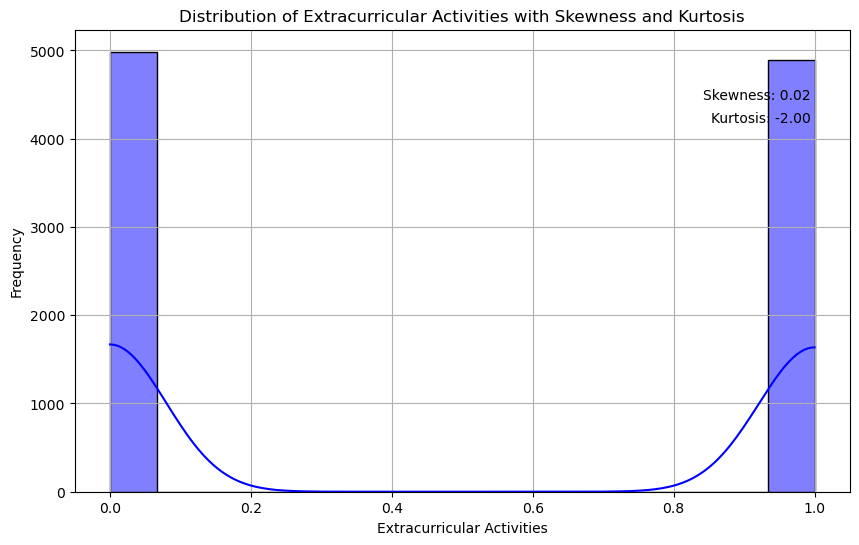

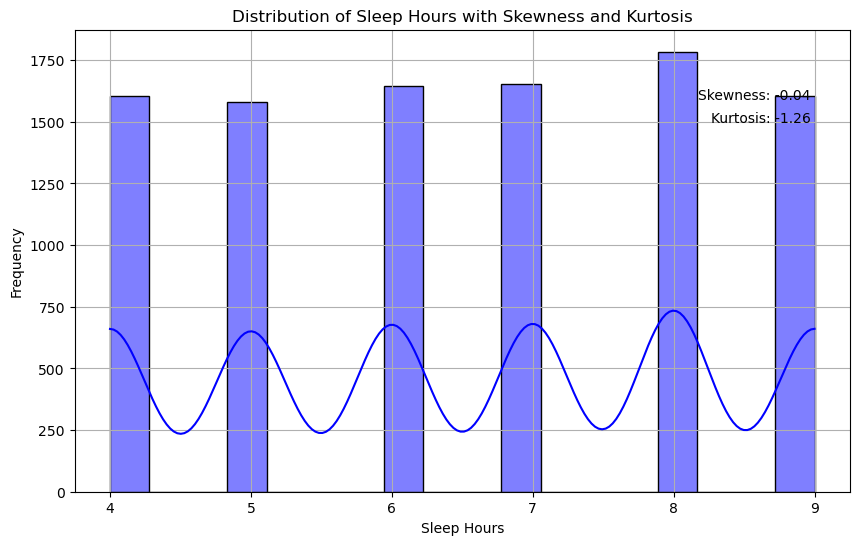

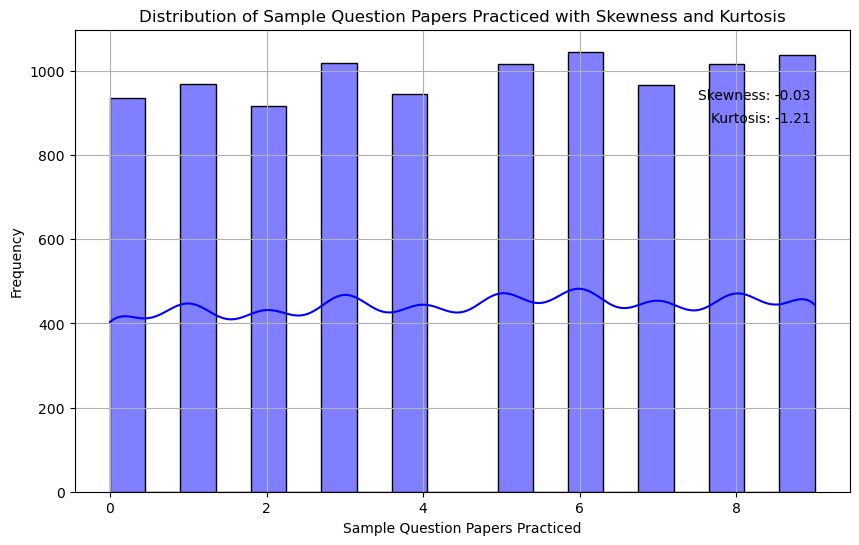

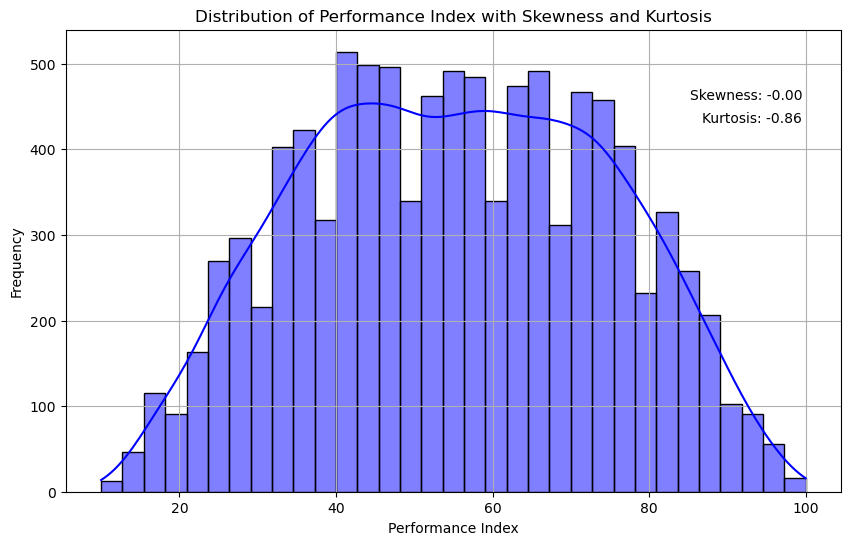

In [22]:
for col in visual_df.columns:
  dist_plot(visual_df, col)

In [36]:
visual_df["grade"] = visual_df["Performance Index"].apply(mapping_function)

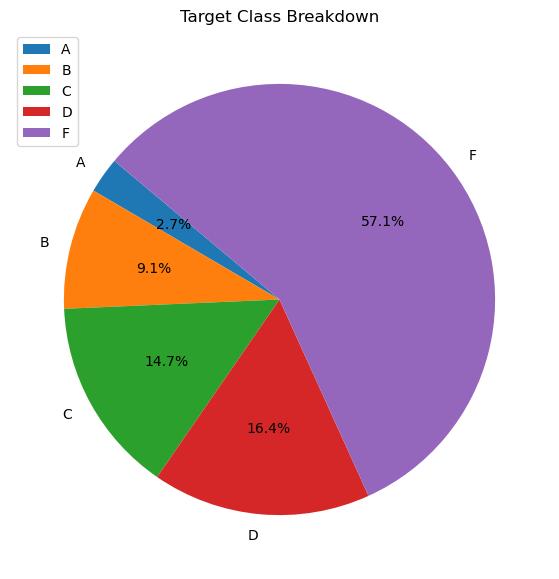

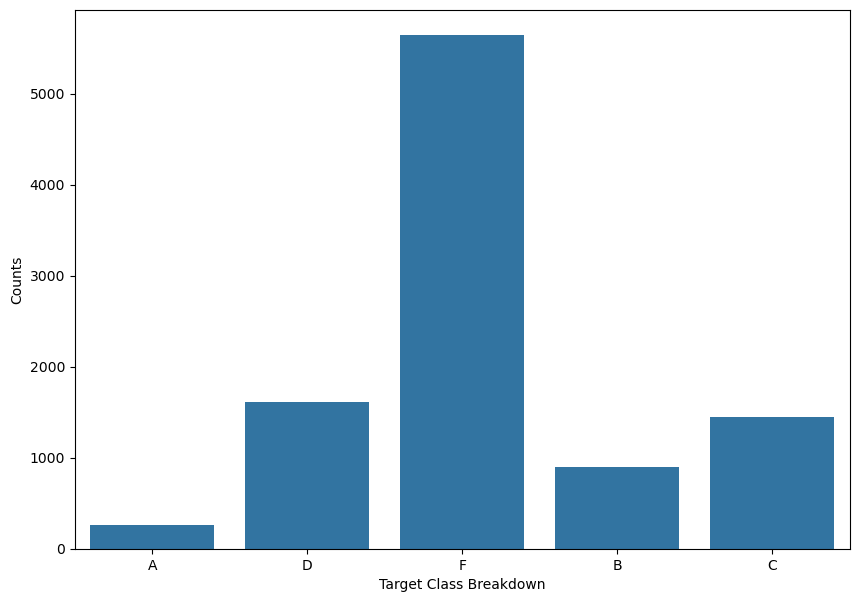

In [41]:
check_class_imbalance(visual_df["grade"])

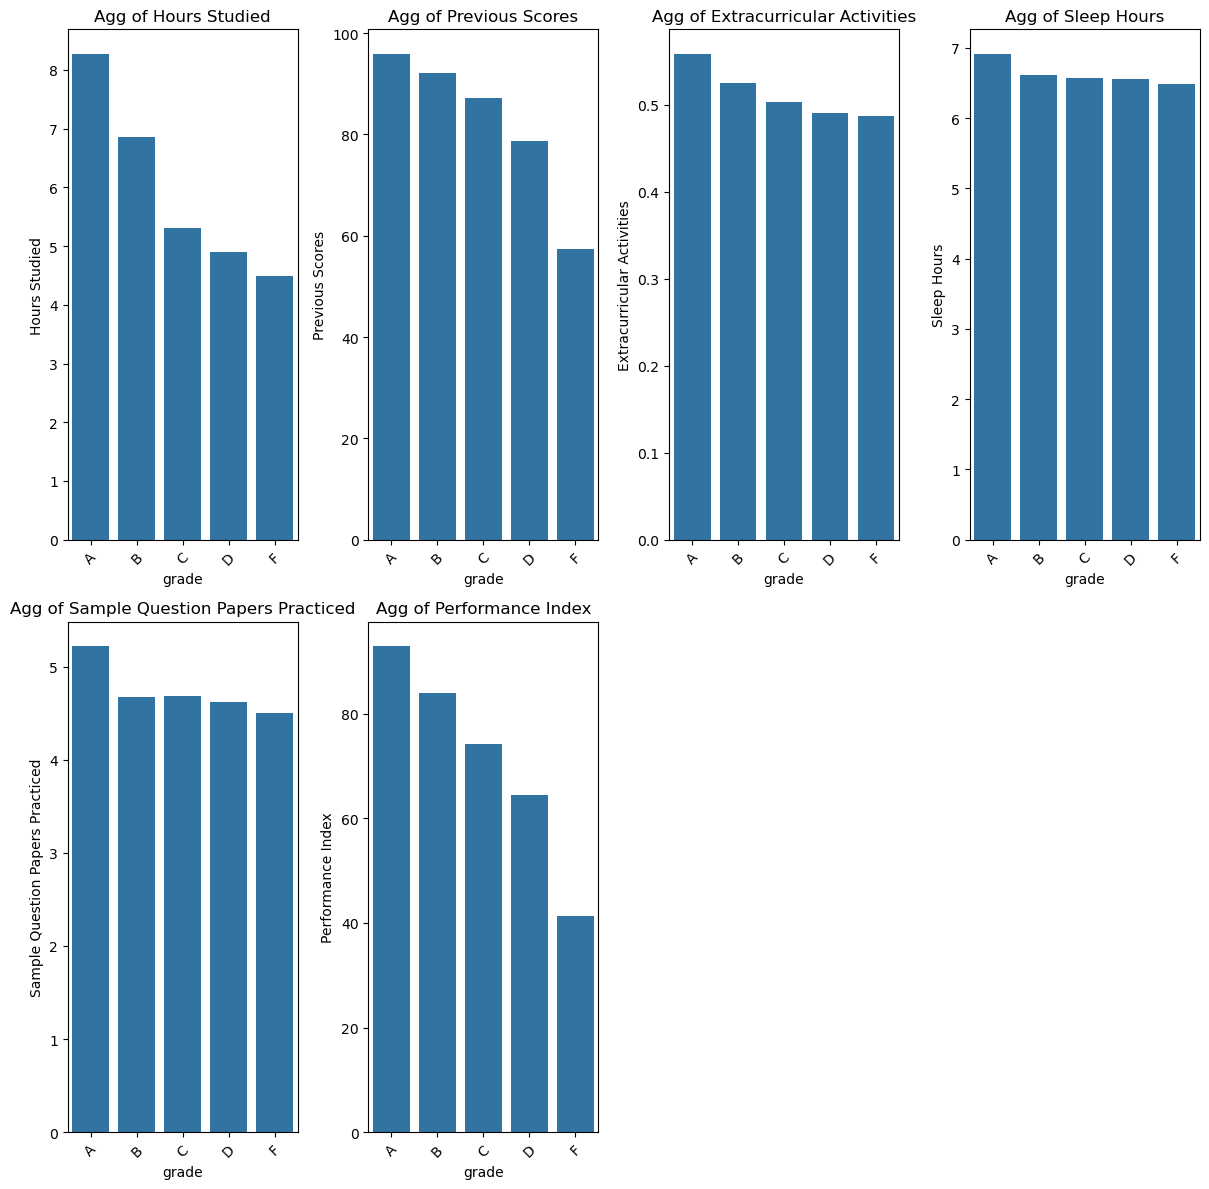

In [42]:
aggregate_dataset(visual_df, visual_df.columns, "grade", "mean")

In [54]:
best_students = visual_df[visual_df["grade"] == "A"]
worst_students = visual_df[visual_df["grade"] == "F"]

In [59]:
best_students

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index,grade
0,7,99,1,9,1,91.0,A
55,6,99,0,4,7,91.0,A
61,9,97,1,8,5,98.0,A
68,9,94,0,9,1,91.0,A
87,9,99,0,4,1,95.0,A
...,...,...,...,...,...,...,...
9658,9,92,1,9,6,91.0,A
9844,8,95,0,9,6,92.0,A
9922,9,94,1,7,8,91.0,A
9976,8,93,1,9,8,91.0,A


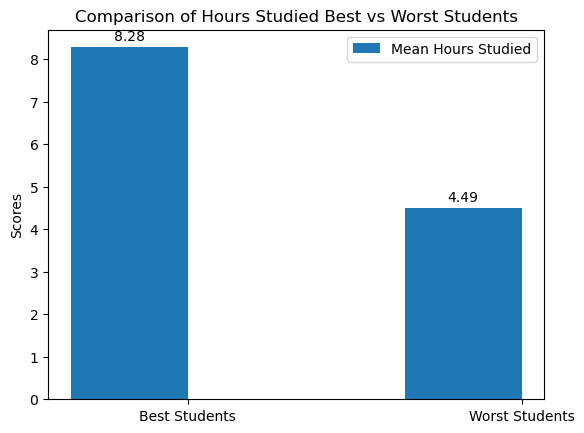

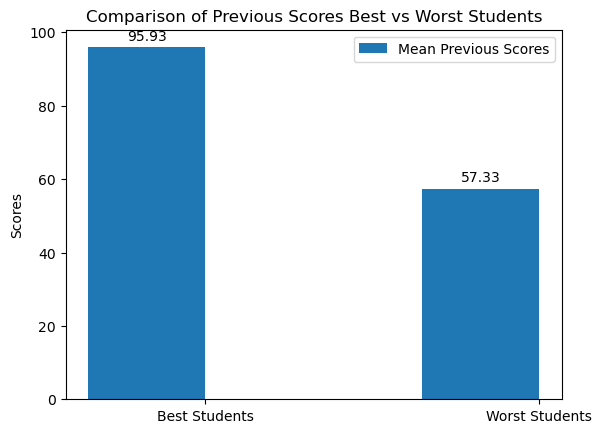

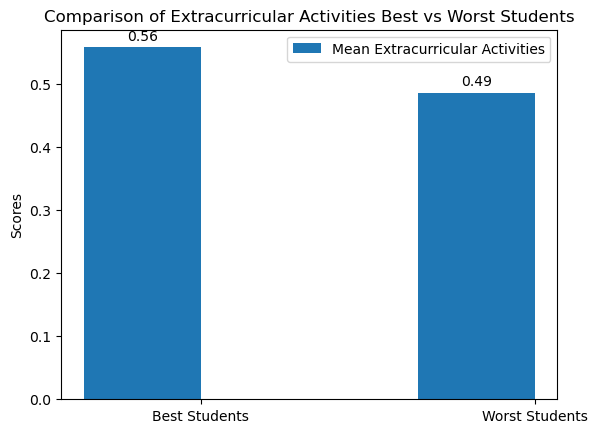

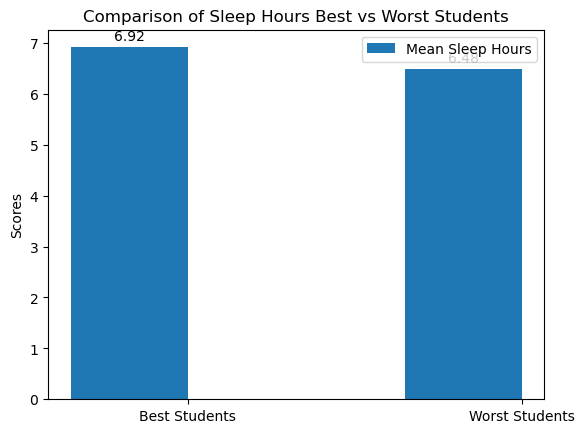

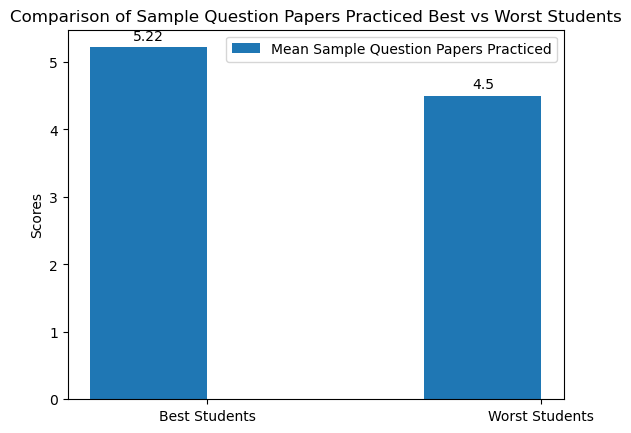

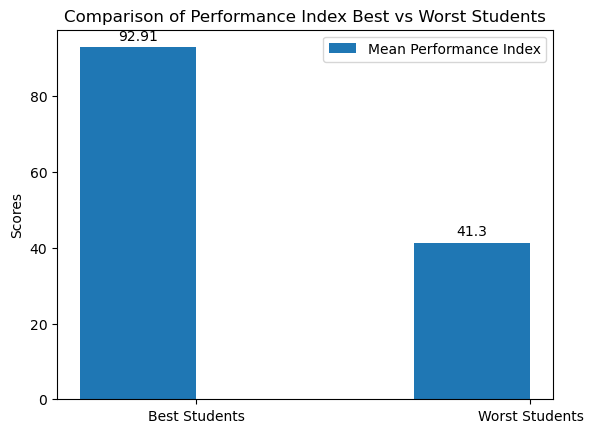

In [70]:
side_by_side(best_students, worst_students, visual_df, "grade")

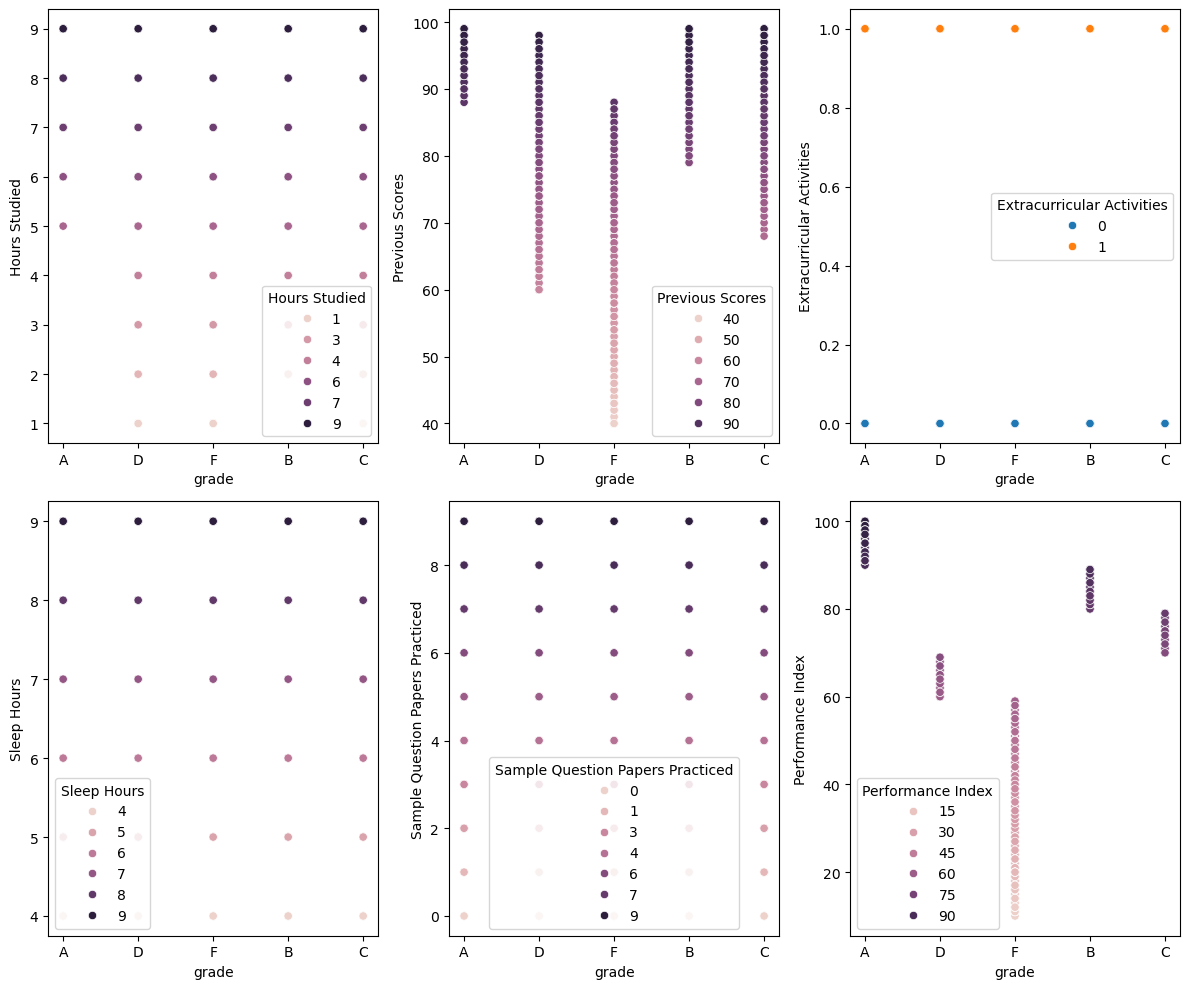

In [44]:
scatter_plot(visual_df, visual_df.columns, "grade")

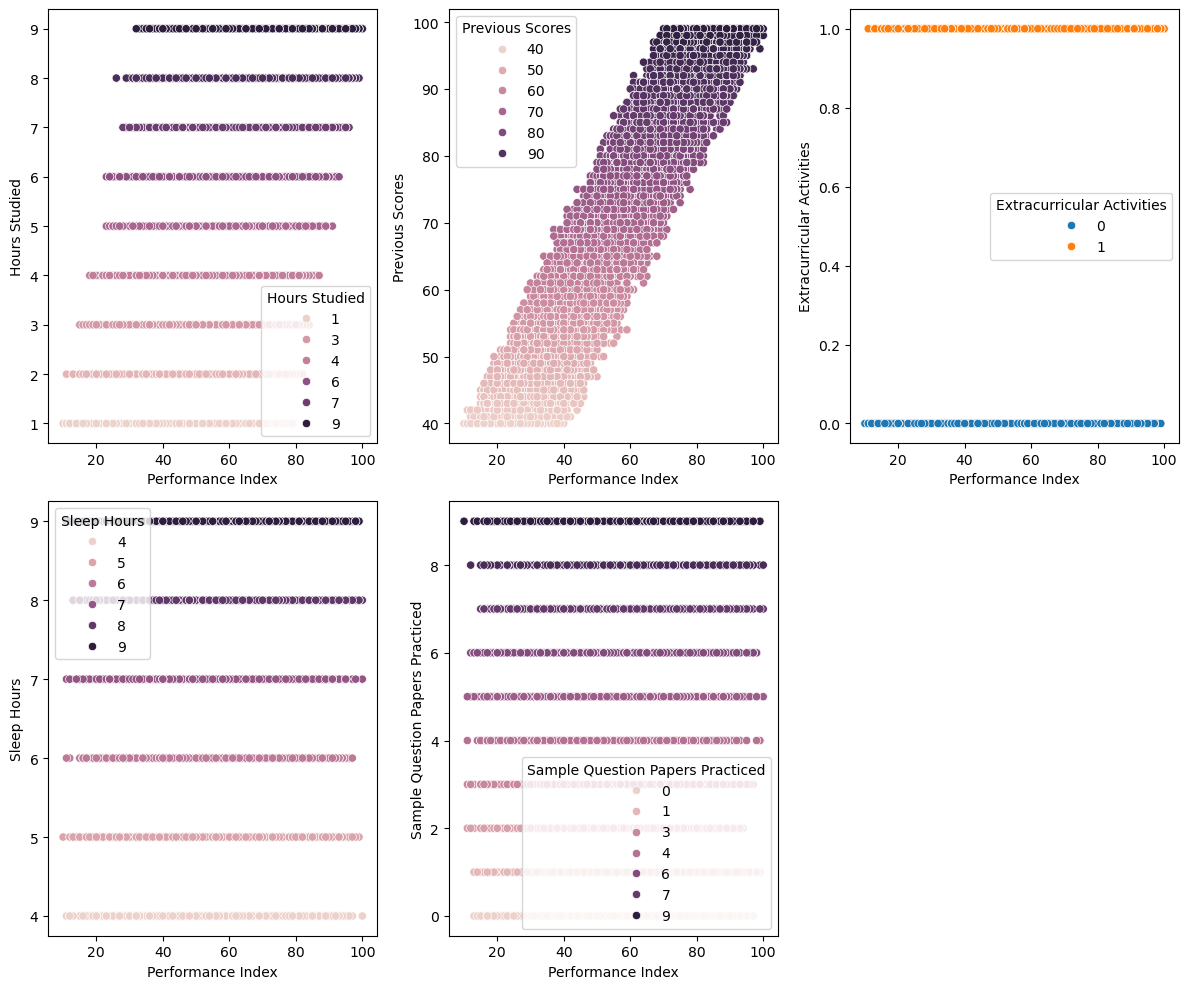

In [73]:
interested_columns = [col for col in visual_df.columns if col != "grade"]
scatter_plot(visual_df, interested_columns, "Performance Index")

/var/folders/bb/2qsf8cm95jg05zrms2_8m2qr0000gn/T/ipykernel_10278/470597227.py:141: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax.plot(x, p, 'k', linewidth=2, color='red', label='Normal Distribution')
/var/folders/bb/2qsf8cm95jg05zrms2_8m2qr0000gn/T/ipykernel_10278/470597227.py:141: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax.plot(x, p, 'k', linewidth=2, color='red', label='Normal Distribution')
/var/folders/bb/2qsf8cm95jg05zrms2_8m2qr0000gn/T/ipykernel_10278/470597227.py:141: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax.plot(x, p, 'k', linewidth=2, color='red', label='Normal Distribution')
/var/folde

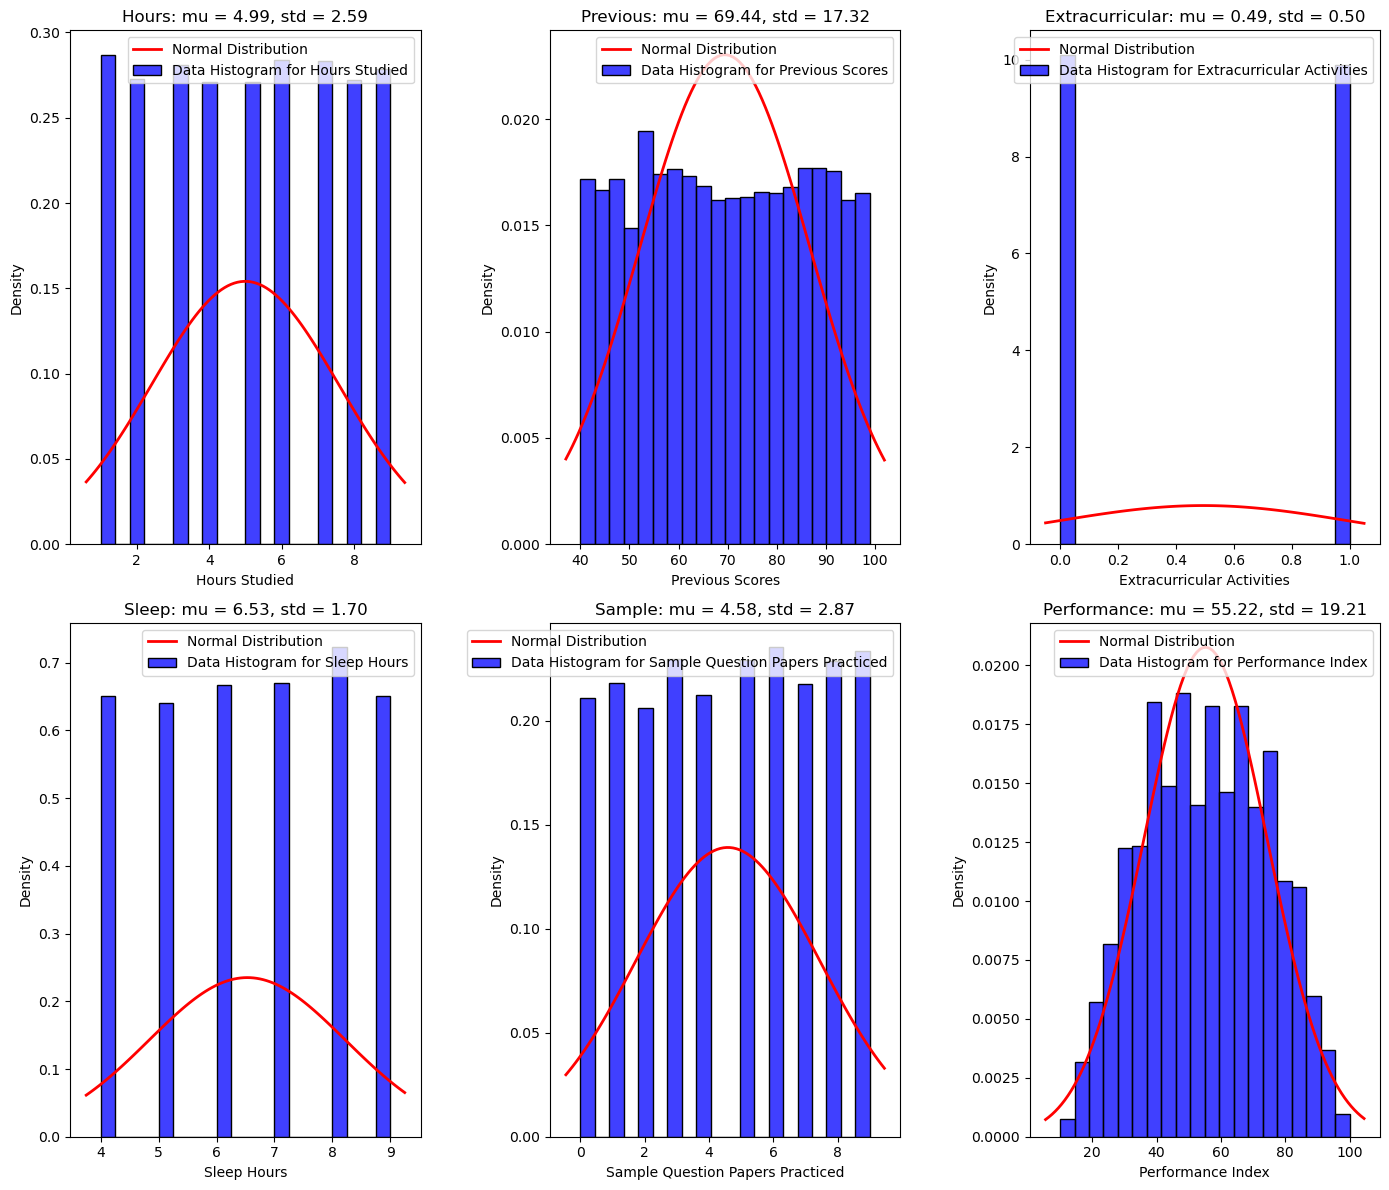

In [53]:
histogram(visual_df, visual_df.columns)

# Anderson-Darling Test

In [77]:
anderson_darling_test(visual_df, interested_columns)

------------HOURS STUDIED------------
Statistic: 186.229
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)
------------PREVIOUS SCORES------------
Statistic: 116.171
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)
------------EXTRACURRICULAR ACTIVITIES------------
Statistic: 1773.673
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)
------------SLEEP HOURS----

# Pearson Correlation

In [84]:
corr, p = stats.pearsonr(visual_df["Previous Scores"], visual_df["Performance Index"])
print('Correlation=%.3f, p=%.3f' % (corr, p))
if p > 0.05:
    print('No significant correlation (fail to reject H0)')
else:
    print('Significant correlation (reject H0)')

Correlation=0.915, p=0.000
Significant correlation (reject H0)


In [85]:
chi_value_tests(visual_df, interested_columns, "grade")

Column Is: Hours Studied
Chi-Square Test:
Chi2 Statistic: 1417.0248395872572, P-value: 8.809633596509873e-278
Column Is: Previous Scores
Chi-Square Test:
Chi2 Statistic: 11016.780140623649, P-value: 0.0
Column Is: Extracurricular Activities
Chi-Square Test:
Chi2 Statistic: 9.571568551749882, P-value: 0.04829726458269011
Column Is: Sleep Hours
Chi-Square Test:
Chi2 Statistic: 35.76075619421216, P-value: 0.016407275408280894
Column Is: Sample Question Papers Practiced
Chi-Square Test:
Chi2 Statistic: 56.11109202801943, P-value: 0.01748498587908222
Column Is: Performance Index
Chi-Square Test:
Chi2 Statistic: 39492.0, P-value: 0.0


In [89]:
categorical_types = df.select_dtypes(include="object")
numeric_types = df.select_dtypes(exclude="object").drop("Performance Index", axis=1)

In [90]:
preprocessor = create_preprocessor(numeric_types.columns, categorical_types.columns)
preprocessor

ColumnTransformer(transformers=[('Categorical',
                                 Pipeline(steps=[('Encoder', OneHotEncoder())]),
                                 Index(['Extracurricular Activities'], dtype='object')),
                                ('Numeric',
                                 Pipeline(steps=[('Scaler', StandardScaler())]),
                                 Index(['Hours Studied', 'Previous Scores', 'Sleep Hours',
       'Sample Question Papers Practiced'],
      dtype='object'))])

# Separate Features

In [91]:
X = df.drop("Performance Index", axis=1)
y = df["Performance Index"]

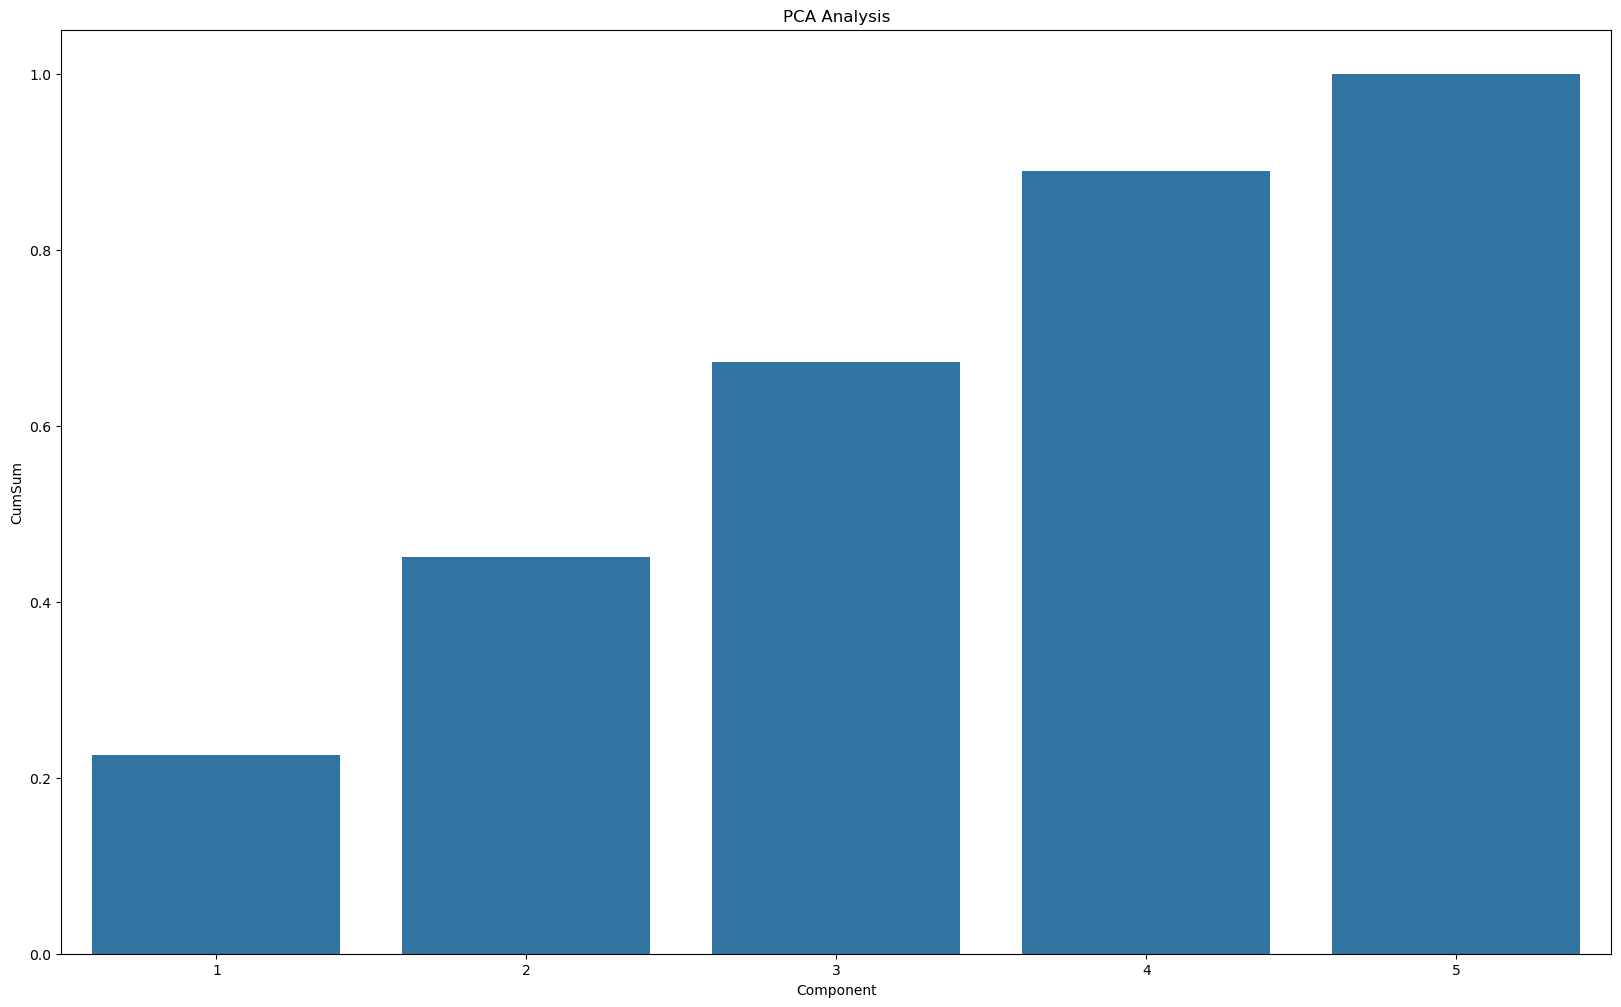

,Component,CumSum
0,1,0.226091
1,2,0.451057
2,3,0.672195
3,4,0.889096
4,5,1.000000


In [92]:
pca_analysis(X, preprocessor)

In [93]:
MAE = make_scorer(score_func=mean_absolute_error, greater_is_better =False)
MSE = make_scorer(score_func=mean_squared_error, greater_is_better=False)
R2 = make_scorer(score_func=r2_score, greater_is_better=True)
EXP_VAR = make_scorer(score_func=explained_variance_score, greater_is_better=True)

In [94]:
model_names = ["DUMMY"]
models = get_selected_models(model_names)
test_selected_models(preprocessor, model_names, models, X, y, MSE)

,Model,Mean,Var,STD,MAE,MSE,RMSE,R2,Explained Var
0,DUMMY,-369.01,126.393,11.242,16.202,369.02,4.383,-0.0,-0.0


In [95]:
model_names = ["SVR"]
models = get_selected_models(model_names)
kbest = mutual_info_regression
test_kbest_columns(preprocessor, X, y, models[0], model_names[0], kbest)

,Model,K,MAE,MSE,RMSE,R2,Explained Var
0,SVR,1,6.625729,59.901656,7.739616,0.836232,0.836385
1,SVR,2,1.903009,5.725827,2.392870,0.984346,0.984352
2,SVR,3,1.886119,5.653097,2.377624,0.984545,0.984551
3,SVR,4,1.833383,5.566759,2.359398,0.984781,0.984788
4,SVR,5,1.802635,5.207462,2.281986,0.985763,0.985770


In [96]:
kbest = f_regression
test_kbest_columns(preprocessor, X, y, models[0], model_names[0], kbest)

,Model,K,MAE,MSE,RMSE,R2,Explained Var
0,SVR,1,6.625729,59.901656,7.739616,0.836232,0.836385
1,SVR,2,1.903009,5.725827,2.392870,0.984346,0.984352
2,SVR,3,1.819707,5.269672,2.295577,0.985593,0.985601
3,SVR,4,1.833383,5.566759,2.359398,0.984781,0.984788
4,SVR,5,1.818919,5.506903,2.346679,0.984944,0.984956


In [98]:
model_names = ["LR", "SVR", "KNN"]
models = get_selected_models(model_names)
kbest = SelectKBest(score_func=mutual_info_regression, k=3)
test_selected_models(preprocessor, model_names, models, X, y, MSE, kbest)

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,Model,Mean,Var,STD,MAE,MSE,RMSE,R2,Explained Var
0,LR,-4.928,0.091,0.302,1.770,4.951,1.492,0.987,0.987
1,SVR,-5.316,0.082,0.286,1.846,5.400,1.524,0.985,0.985
2,KNN,-6.081,0.153,0.391,1.980,6.191,1.577,0.983,0.983


In [99]:
model_names = ["LR", "SVR", "KNN"]
models = get_selected_models(model_names)
kbest = SelectKBest(score_func=mutual_info_regression, k=5)
test_selected_models(preprocessor, model_names, models, X, y, MSE, kbest)

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,Model,Mean,Var,STD,MAE,MSE,RMSE,R2,Explained Var
0,LR,-4.360,0.094,0.307,1.650,4.309,1.441,0.988,0.988
1,SVR,-5.153,0.075,0.273,1.790,5.171,1.508,0.986,0.986
2,KNN,-7.823,1.134,1.065,2.272,8.115,1.688,0.978,0.978


In [101]:
model_names = ["XGB", "GBR", "RFR", "LASSO", "RIDGE"]
models = get_selected_models(model_names)
kbest = SelectKBest(score_func=mutual_info_regression, k=5)
test_selected_models(preprocessor, model_names, models, X, y, MSE, kbest)

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,Model,Mean,Var,STD,MAE,MSE,RMSE,R2,Explained Var
4,RIDGE,-4.327,0.074,0.272,1.630,4.211,1.433,0.989,0.989
1,GBR,-4.576,0.089,0.298,1.702,4.577,1.463,0.988,0.988
0,XGB,-5.155,0.082,0.287,1.820,5.217,1.511,0.986,0.986
2,RFR,-5.901,0.272,0.521,1.943,5.894,1.558,0.984,0.984
3,LASSO,-7.268,0.092,0.304,2.153,7.268,1.642,0.980,0.980


In [102]:
params = {
  'RIDGE': {
        'model__alpha': [0.01, 0.1, 1, 10, 100],
        'model__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
    },
    'LASSO': {
        'model__alpha': [0.01, 0.1, 1, 10, 100],
        'model__max_iter': [1000, 5000, 10000]
    },
  
    'DTR': {
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 10, 20],
        'model__min_samples_leaf': [1, 5, 10]
    },
    'RFR': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 10, 20],
        'model__min_samples_leaf': [1, 5, 10]
    },
    'GBR': {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7],
        'model__min_samples_split': [2, 4, 6],
        'model__min_samples_leaf': [1, 2, 4]
    },
    'SVR': {
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf'],
        'model__gamma': ['scale', 'auto']
    },
    'KNN': {
        'model__n_neighbors': [3, 5, 10, 15],
        'model__weights': ['uniform', 'distance'],
        'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'model__leaf_size': [10, 30, 50],
        'model__p': [1, 2]
    },
    'XGB': {
        'model__n_estimators': [100, 150, 200],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__max_depth': [3, 5, 7],
        'model__subsample': [0.6, 0.8, 1.0],
        'model__colsample_bytree': [0.6, 0.8, 1.0],
        'model__gamma': [0, 0.1, 0.2],  # Minimum loss reduction required to make a further partition on a leaf node
        'model__reg_alpha': [0, 0.1, 0.5],  # L1 regularization term on weights
        'model__reg_lambda': [1, 1.5, 2.0]  # L2 regularization term on weights
    }
}

In [105]:
model_names = ["XGB", "GBR", "RFR","LASSO", "RIDGE", "KNN", "SVR"]
new_models = get_selected_models(model_names)
optimization_search(preprocessor, model_names, new_models, X, y, RandomizedSearchCV, params, MSE, kbest)

The Best Param: {'model__subsample': 1.0, 'model__reg_lambda': 1.5, 'model__reg_alpha': 0, 'model__n_estimators': 100, 'model__max_depth': 3, 'model__learning_rate': 0.1, 'model__gamma': 0.2, 'model__colsample_bytree': 1.0} for Model: XGB
The Best Param: {'model__n_estimators': 300, 'model__min_samples_split': 2, 'model__min_samples_leaf': 4, 'model__max_depth': 3, 'model__learning_rate': 0.2} for Model: GBR
The Best Param: {'model__n_estimators': 300, 'model__min_samples_split': 10, 'model__min_samples_leaf': 5, 'model__max_depth': 20} for Model: RFR
The Best Param: {'model__max_iter': 1000, 'model__alpha': 0.01} for Model: LASSO
The Best Param: {'model__solver': 'lsqr', 'model__alpha': 0.01} for Model: RIDGE
The Best Param: {'model__weights': 'uniform', 'model__p': 1, 'model__n_neighbors': 10, 'model__leaf_size': 30, 'model__algorithm': 'ball_tree'} for Model: KNN


/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


The Best Param: {'model__kernel': 'linear', 'model__gamma': 'scale', 'model__C': 1} for Model: SVR


,Model,MAE,MSE,RMSE,R2,Explained Var
4,RIDGE,1.640508,4.284769,2.069968,0.988286,0.988299
6,SVR,1.640699,4.285952,2.070254,0.988282,0.988297
3,LASSO,1.641588,4.290906,2.071450,0.988269,0.988282
1,GBR,1.687396,4.535633,2.129703,0.987600,0.987611
0,XGB,1.701536,4.599535,2.144653,0.987425,0.987441
2,RFR,1.776790,5.032188,2.243254,0.986242,0.986249
5,KNN,2.469715,9.653839,3.107063,0.973607,0.973634


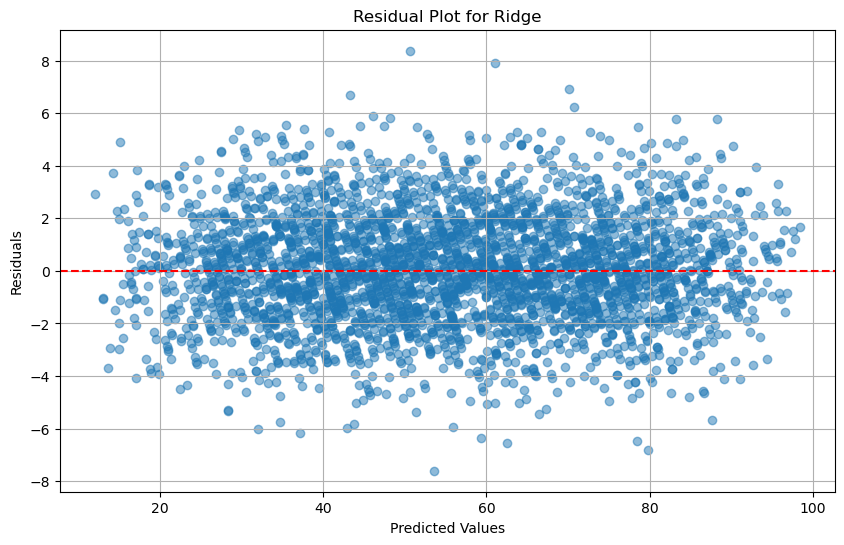

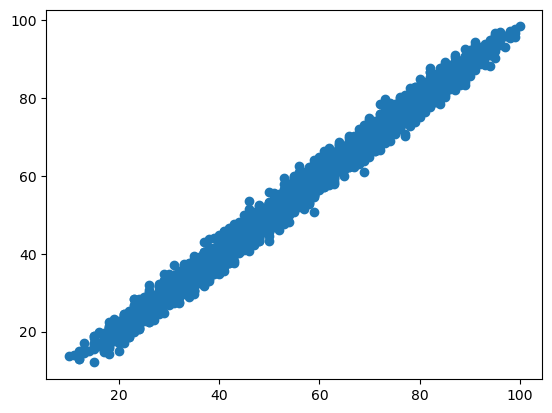

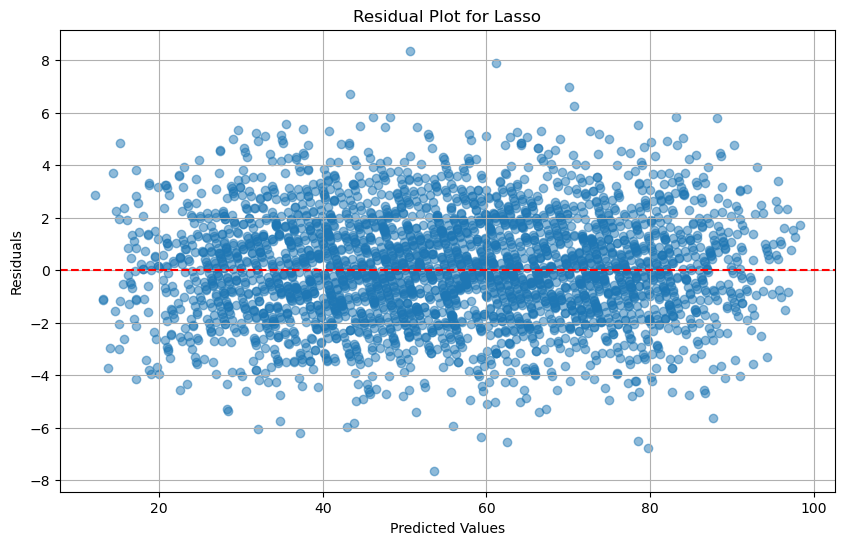

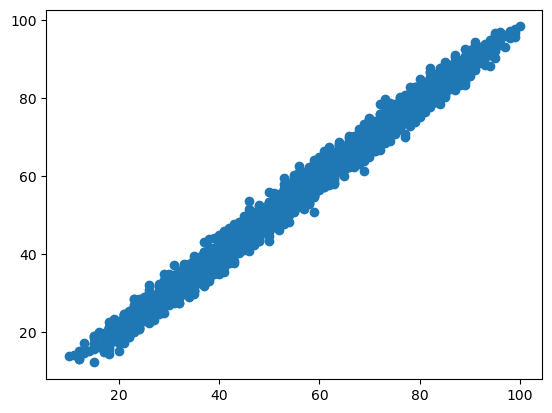

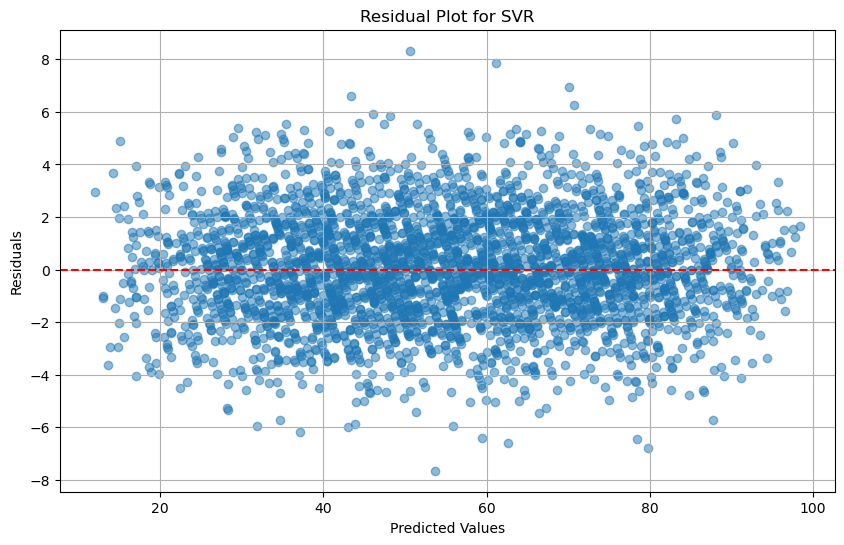

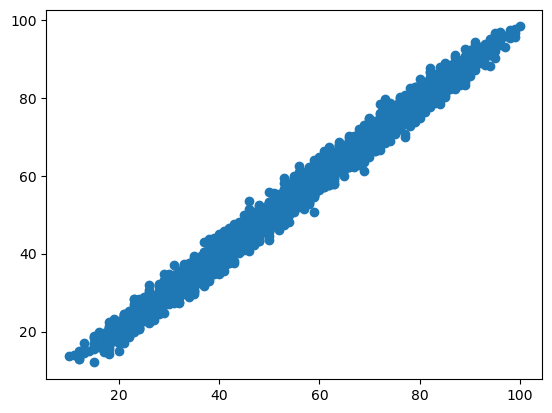

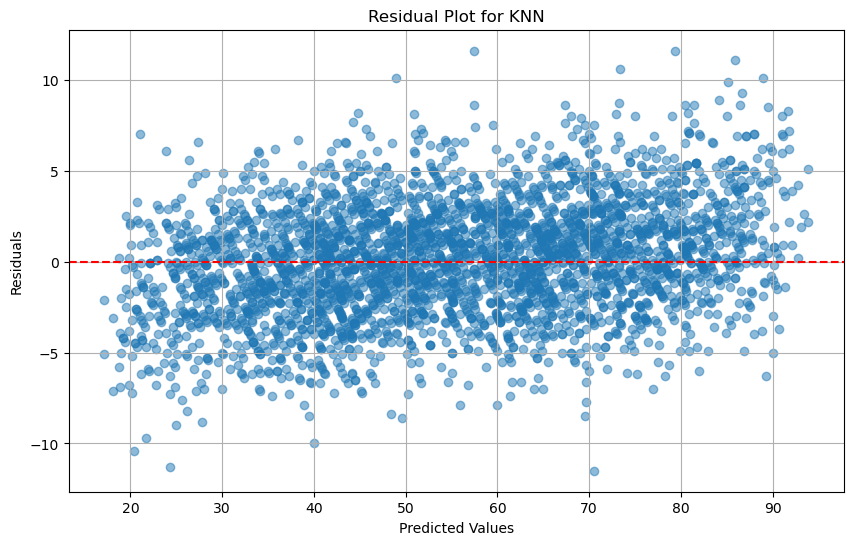

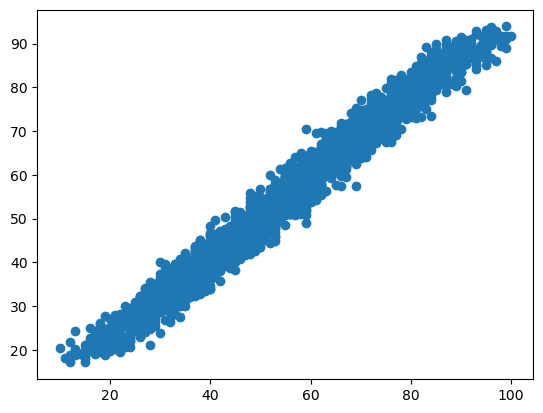

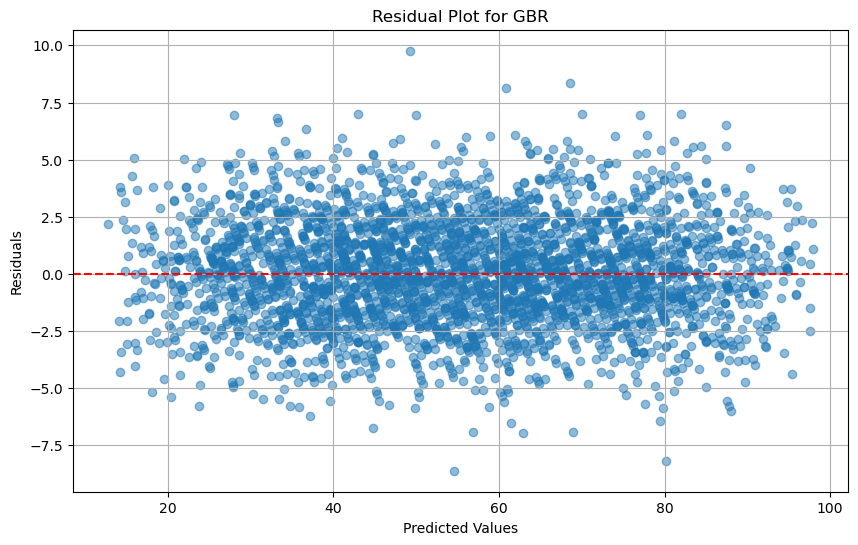

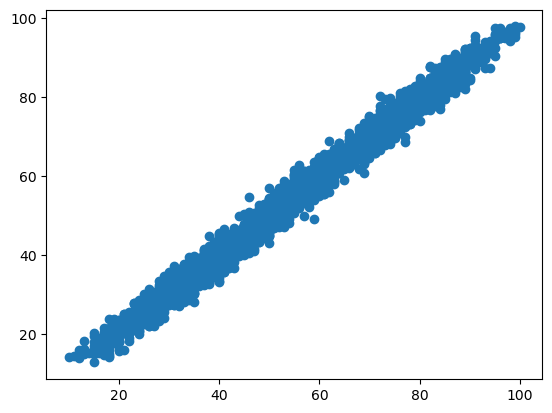

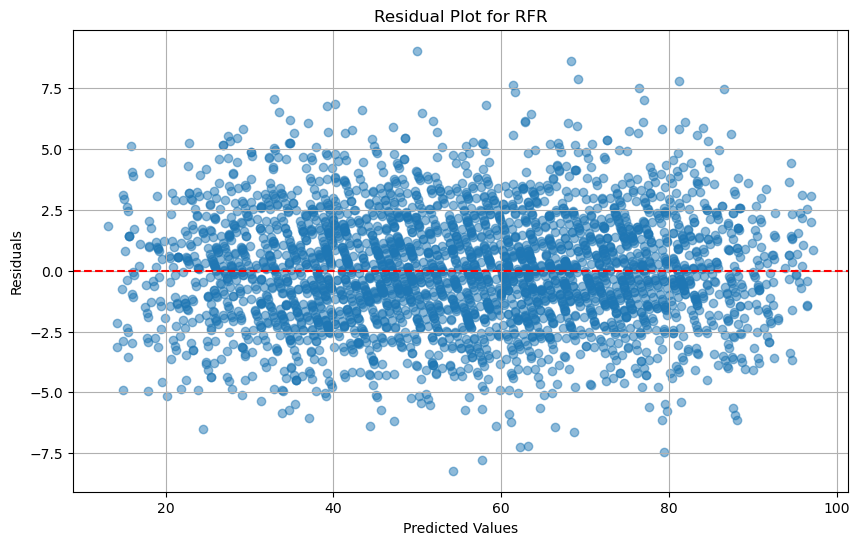

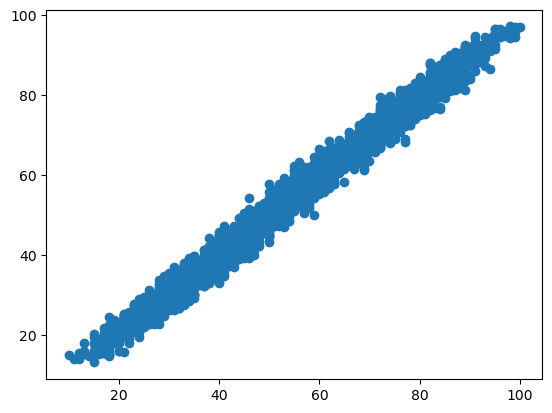

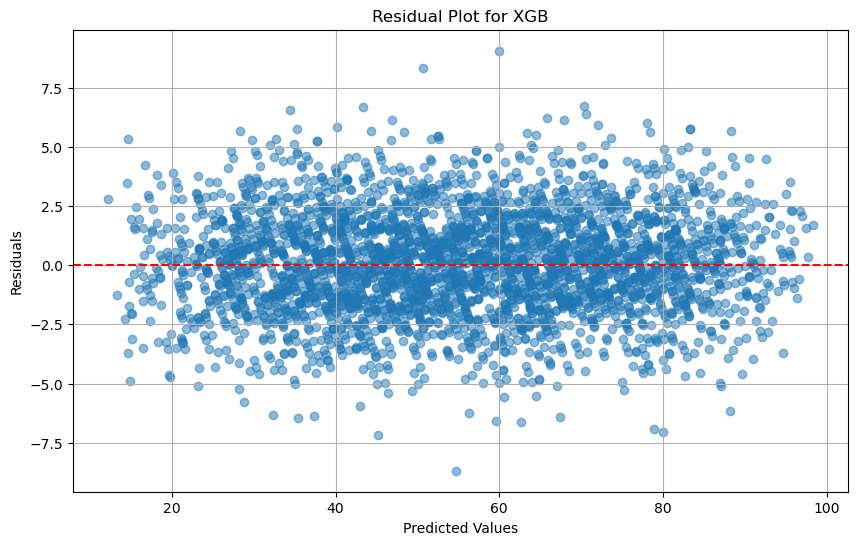

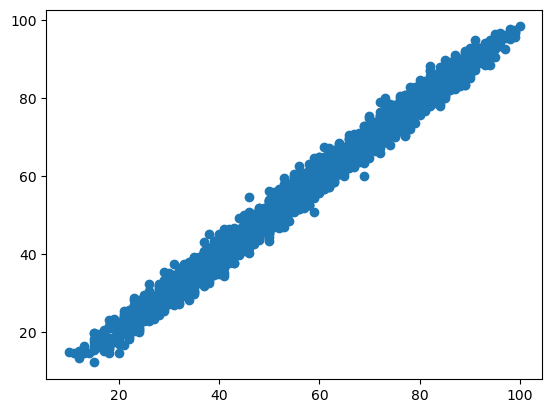

In [110]:
models = [
  Ridge(solver='lsqr', alpha=0.01),
  Lasso(max_iter=1000, alpha=0.01),
  SVR(kernel='linear', gamma='scale', C=1),
  KNeighborsRegressor(weights='uniform', p=1, n_neighbors=10, leaf_size=30, algorithm='ball_tree'),
  GradientBoostingRegressor(n_estimators=300, min_samples_split=2, min_samples_leaf=4, max_depth=3, learning_rate=0.2),
  RandomForestRegressor(n_estimators=300, min_samples_split=10, min_samples_leaf=5, max_depth=20),
  XGBRegressor(subsample=1.0, reg_lambda=1.5, reg_alpha=0, n_estimators=100, max_depth=3, learning_rate=0.1, gamma=0.2, colsample_bytree=1.0)
]

model_names = [
  'Ridge',
  "Lasso",
  "SVR",
  "KNN",
  "GBR",
  "RFR",
  "XGB"
]

residual_plot(models, model_names, preprocessor, kbest, X, y)

In [112]:
params = {
    
'XGB': {
        'model__n_estimators': [100, 150, 200],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__max_depth': [3, 5, 7],
        'model__subsample': [0.6, 0.8, 1.0],
        'model__colsample_bytree': [0.6, 0.8, 1.0],
        # 'model__gamma': [0, 0.1, 0.2],  # Minimum loss reduction required to make a further partition on a leaf node
        # 'model__reg_alpha': [0, 0.1, 0.5],  # L1 regularization term on weights

    }

}

model_names = ["XGB"]
new_models = get_selected_models(model_names)
optimization_search(preprocessor, model_names, new_models, X, y, RandomizedSearchCV, params, MSE, kbest)

The Best Param: {'model__subsample': 0.8, 'model__n_estimators': 200, 'model__max_depth': 5, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.6} for Model: XGB


,Model,MAE,MSE,RMSE,R2,Explained Var
0,XGB,1.678246,4.478596,2.116269,0.987756,0.987768
